## MSDS 7331: Data Mining

## Mini Lab: Logistic Regression and SVMs

## 9 June 2019

## Authors: Meredith Ludlow, Anand Rajan, Kristen Rollins, and Tej Tenmattam

---

### Create Models

<div class="alert alert-block alert-info">
<b>Rubric 1:</b> Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.
</div>

#### Preparing Data

In [2]:
# importing necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Set seaborn plot styles
sns.set_style('darkgrid')
sns.set_color_codes('muted')

#uncomment when ready to turn in report
#import warnings
#warnings.filterwarnings("ignore") # ignore warnings for clean report

# df.head() displays all the columns without truncating
pd.set_option('display.max_columns', None)

# read csv file as pandas dataframe
df_17_census = pd.read_csv('Data/acs2017_census_tract_data.csv')

In [3]:
# Clean dataset as in lab 1
df_17_census.set_index('TractId', inplace=True) # set tract id as index

# Drop tracts where population is 0
df_17_cln = df_17_census.drop(df_17_census[df_17_census.TotalPop == 0].index)

# Drop tracts where child poverty or unemployment is null
df_17_cln = df_17_cln[np.isfinite(df_17_cln['ChildPoverty'])]
df_17_cln = df_17_cln[np.isfinite(df_17_cln['Unemployment'])]

# Impute to the median by each state
df_grouped = df_17_cln.groupby('State').transform(lambda x: x.fillna(x.median()))
df_17_cln['Income'] = df_grouped['Income']
df_17_cln['IncomeErr'] = df_grouped['IncomeErr']

# Impute remaining values to the overall median
df_17_cln = df_17_cln.fillna(df_17_cln.median())

In [4]:
# Categorize the unemployed percentages into binary categories
# Make cutoff using median of clean dataset, so groups are roughly equal
df_17_cln['HighUnemployment'] = pd.cut(df_17_cln.Unemployment,[-1,6,101],labels=[0,1])                                 
df_17_cln.HighUnemployment = df_17_cln.HighUnemployment.astype(np.int)
# 0 indicates low unemployment rate, 1 indicates high unemployment rate

df_17_cln.info() # matches cleaned dataset from lab 1

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 37 columns):
State               72889 non-null object
County              72889 non-null object
TotalPop            72889 non-null int64
Men                 72889 non-null int64
Women               72889 non-null int64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null int64
Income              72889 non-null float64
IncomeErr           72889 non-null float64
IncomePerCap        72889 non-null float64
IncomePerCapErr     72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 

In [5]:
# Create dataframe to use in logistic and SVM models
df_17_model = df_17_cln.copy()

# Eliminate non-useful and redundant variables
del df_17_model['State'] # encoding would result in too many added variables
del df_17_model['County'] # encoding would result in too many added variables
del df_17_model['Men'] # redundant to keep men and women
del df_17_model['Unemployment'] # already encoded to binary

# Eliminate more variables based on correlation plot (TODO maybe remove more)
del df_17_model['IncomeErr'] # only need to keep one income-related variable
del df_17_model['IncomePerCap'] # only need to keep one income-related variable
del df_17_model['IncomePerCapErr'] # only need to keep one income-related variable
del df_17_model['Transit'] # drive and transit were essentially inverses
del df_17_model['PublicWork'] # private and public work were essentially inverses

# All remaining variables are ints or floats so we do not have to do one-hot encoding

# Convert columns to percentages for consistency
df_17_model['Women'] = round(df_17_model['Women']/df_17_model['TotalPop']*100,1)
df_17_model['VotingAgeCitizen'] = round(df_17_model['VotingAgeCitizen']/df_17_model['TotalPop']*100,1)
df_17_model['Employed'] = round(df_17_model['Employed']/df_17_model['TotalPop']*100,1)

# TODO maybe further dimension reduction via PCA

print(df_17_model.info())
df_17_model.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72889 entries, 1001020100 to 72153750602
Data columns (total 28 columns):
TotalPop            72889 non-null int64
Women               72889 non-null float64
Hispanic            72889 non-null float64
White               72889 non-null float64
Black               72889 non-null float64
Native              72889 non-null float64
Asian               72889 non-null float64
Pacific             72889 non-null float64
VotingAgeCitizen    72889 non-null float64
Income              72889 non-null float64
Poverty             72889 non-null float64
ChildPoverty        72889 non-null float64
Professional        72889 non-null float64
Service             72889 non-null float64
Office              72889 non-null float64
Construction        72889 non-null float64
Production          72889 non-null float64
Drive               72889 non-null float64
Carpool             72889 non-null float64
Walk                72889 non-null float64
OtherTransp       

,TotalPop,Women,Hispanic,White,Black,Native,Asian,Pacific,VotingAgeCitizen,Income,Poverty,ChildPoverty,Professional,Service,Office,Construction,Production,Drive,Carpool,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,SelfEmployed,FamilyWork,HighUnemployment
TractId,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1001020100,1845,51.3,2.4,86.3,5.2,0.0,1.2,0.0,76.3,67826.0,10.7,20.8,38.5,15.6,22.8,10.8,12.4,94.2,3.3,0.5,0.0,2.1,24.5,47.8,74.2,4.5,0.0,0
1001020200,2172,46.3,1.1,41.6,54.5,0.0,1.0,0.0,76.1,41287.0,22.4,35.8,30.5,24.9,22.9,6.3,15.4,90.5,9.1,0.0,0.5,0.0,22.2,39.2,75.9,9.0,0.0,0
1001020300,3385,54.7,8.0,61.4,26.5,0.6,0.7,0.4,73.3,46806.0,14.7,21.1,27.9,19.4,33.3,9.9,9.6,88.3,8.4,1.0,0.8,1.5,23.1,43.8,73.3,4.8,0.7,0
1001020400,4267,53.1,9.6,80.3,7.1,0.5,0.2,0.0,76.3,55895.0,2.3,1.7,29.0,16.6,25.8,9.1,19.5,82.3,11.2,1.5,2.9,2.1,25.9,43.3,75.8,4.5,0.0,1
1001020500,9965,49.3,0.9,77.5,16.4,0.0,3.1,0.0,72.5,68143.0,12.2,17.9,48.8,13.8,20.5,3.5,13.4,86.9,11.2,0.8,0.3,0.7,21.0,48.0,71.4,4.5,0.0,0


#### Train/Test Split

In [6]:
# Following code from Dr. Larson's Logits and SVM notebook
# Question: should we actually use cross-validation for this lab? (rubric doesn't mention it)
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'HighUnemployment' in df_17_model:
    y = df_17_model['HighUnemployment'].values # get the labels we want
    del df_17_model['HighUnemployment'] # get rid of the class label
    X = df_17_model.values # use everything else to predict
    
# 10 fold cross-validation
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=None, test_size=0.2, train_size=None)


#### Logistic Regression

In [7]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
# also scale variables
from sklearn.preprocessing import StandardScaler
scl_obj = StandardScaler()

# TODO repeat and try out different learning parameters and constants
# TODO try to fix warnings - fixed this with solver
lr_clf = LogisticRegression(penalty='l2', C=0.05, class_weight=None, solver='lbfgs') 
        #class_weight=None because unemployment groups are weighted equally

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    # scale attributes by the training set
    scl_obj.fit(X[train_indices])
    X_train_scaled = scl_obj.transform(X[train_indices]) # apply to training
    X_test_scaled = scl_obj.transform(X[test_indices]) # use training scales to adjust test set, so we're not cheating
    
    # train object
    lr_clf.fit(X_train_scaled,y[train_indices])
    # get test set precitions
    y_hat = lr_clf.predict(X_test_scaled)

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("Precision:",mt.precision_score(y[test_indices],y_hat))
    print("Recall:",mt.recall_score(y[test_indices],y_hat))
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))


====Iteration 0  ====
Precision: 0.7574173712528824
Recall: 0.6988652482269504
accuracy 0.7461242968857182
confusion matrix
 [[5950 1578]
 [2123 4927]]
====Iteration 1  ====
Precision: 0.7676204819277108
Recall: 0.708408617095205
accuracy 0.7502400878035396
confusion matrix
 [[5840 1543]
 [2098 5097]]
====Iteration 2  ====
Precision: 0.7630741246020919
Recall: 0.7012118679481822
accuracy 0.745644121278639
confusion matrix
 [[5836 1563]
 [2145 5034]]
====Iteration 3  ====
Precision: 0.7644546147978643
Recall: 0.6977165135059872
accuracy 0.7451639456715599
confusion matrix
 [[5852 1544]
 [2171 5011]]
====Iteration 4  ====
Precision: 0.7664943751900274
Recall: 0.7032078103207811
accuracy 0.748662367951708
confusion matrix
 [[5872 1536]
 [2128 5042]]
====Iteration 5  ====
Precision: 0.7534534534534535
Recall: 0.6964607911172797
accuracy 0.7373439429276992
confusion matrix
 [[5731 1642]
 [2187 5018]]
====Iteration 6  ====
Precision: 0.7557519427091269
Recall: 0.6939974814607528
accuracy 0.7

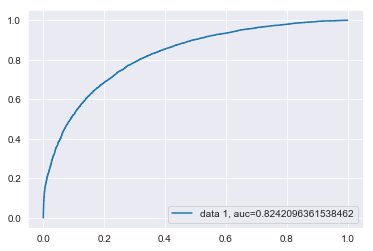

In [8]:
#ROC Curve for LR model above
y_pred_prob = lr_clf.predict_proba(X_test_scaled)[::,1]
fpr, tpr, _ = mt.roc_curve(y[test_indices],  y_pred_prob)
auc = mt.roc_auc_score(y[test_indices], y_pred_prob)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [9]:
# import the necessary packages
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs
import numpy as np
import argparse
 
def sigmoid_activation(x):
# compute and return the sigmoid activation value for a
# given input value
    return 1.0 / (1 + np.exp(-x))

sigmoid_activation(X_train_scaled)
                             

array([[0.54010229, 0.47975858, 0.35000395, ..., 0.66487682, 0.50159344,
        0.40692225],
       [0.4062564 , 0.67007188, 0.41935135, ..., 0.50247258, 0.34383277,
        0.40692225],
       [0.40471001, 0.34722001, 0.87636864, ..., 0.47747995, 0.48202218,
        0.40692225],
       ...,
       [0.65060586, 0.80255351, 0.3529563 , ..., 0.23541475, 0.43667197,
        0.40692225],
       [0.32630483, 0.47379035, 0.39538364, ..., 0.72565623, 0.43667197,
        0.40692225],
       [0.65806742, 0.20214333, 0.36788333, ..., 0.20948507, 0.4755077 ,
        0.72189229]])

In [12]:
# Loss function for gradient descent y=0 to y=1 and y_hat is prediction for best value
# weights and bias are updated until we reach bottom (the minimum point)

def log_loss (y, y_hat):
    return -np.mean(y * np.log(y_hat) + (1 -y) * np.log(1-y_hat))

log_loss(y[test_indices],y_hat)
                             

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


nan

In [11]:
# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)

ols = linear_model.LinearRegression()
ols.fit(X, y)
plt.plot(X_test, ols.coef_ * X_test + ols.intercept_, linewidth=1)
plt.axhline(.5, color='.5')

plt.ylabel('y')
plt.xlabel('X')
plt.xticks(range(-5, 10))
plt.yticks([0, 0.5, 1])
plt.ylim(-.25, 1.25)
plt.xlim(-4, 10)
plt.legend(('Logistic Regression Model', 'Linear Regression Model'),
           loc="lower right", fontsize='small')
plt.tight_layout()
plt.show()

C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """
C:\Users\Anand\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in multiply
  """


nan

#### Support Vector Machine

In [7]:
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test)

In [9]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.748525174921114
[[5773 1680]
 [1986 5139]]


In [10]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(33139, 27)
(33139,)
[16406 16733]


### Model Advantages

<div class="alert alert-block alert-info">
<b>Rubric 2:</b> Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.
</div>

### Interpret Feature Importance

<div class="alert alert-block alert-info">
<b>Rubric 3:</b> Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?
</div>

In [7]:
# TODO use best logistic model we find (lr_clf object)
# sort attributes by weight and spit them out
zip_vars = zip(lr_clf.coef_.T,df_17_model.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out

White has weight of -1.0877580661437716
Employed has weight of -0.6433136267451702
Hispanic has weight of -0.46595382599076873
Black has weight of -0.305921103731918
Asian has weight of -0.21864260396207214
Income has weight of -0.15275117978917715
Professional has weight of -0.11232045473800638
ChildPoverty has weight of -0.08130040158344763
WorkAtHome has weight of -0.07040789803161154
Pacific has weight of -0.06412586057660227
Walk has weight of -0.05346050022263001
TotalPop has weight of -0.039475477851311884
Construction has weight of -0.03939367826950078
Native has weight of -0.03458302017462102
FamilyWork has weight of -0.030590715189962498
SelfEmployed has weight of -0.02219771023257836
Drive has weight of -0.00445408617184769
OtherTransp has weight of 0.03818328156548312
PrivateWork has weight of 0.044271905533371896
Office has weight of 0.04518728654711343
Production has weight of 0.057514215876318386
Carpool has weight of 0.05927099932857496
Women has weight of 0.07930374415

### Interpret Support Vectors

<div class="alert alert-block alert-info">
<b>Rubric 4:</b> Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.
</div>